In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image
import glob


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
print(tf.__version__)

2.2.0-rc2


In [4]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.list_physical_devices('GPU'))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [8]:
print(tf.executing_eagerly())


True


In [0]:
def _read_to_tensor(fname, output_height=256, output_width=256, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    
    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
    return output

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
img_dir = '/content/drive/My Drive/segmentation/image/'
masks_dir='/content/drive/My Drive/segmentation/masks/'

# Required image dimensions
output_height = 256
output_width = 256

In [12]:
def read_images(img_dir,masks_dir):
    '''Function to get all image directories, read images and masks in separate tensors
        Inputs: 
            img_dir - image directory
            masks_dir- masks directory
        Outputs 
            image_tensors, masks_tensors, image files list, mask files list
    '''
    
    # Get the file names list from provided directory
    image_list = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    image_list=sorted(image_list)
    masks_list = [f for f in os.listdir(masks_dir) if os.path.isfile(os.path.join(masks_dir, f))]
    masks_list=sorted(masks_list)

    # Separate image and mask files lists, exclude unnecessary files
    #image_list = [file for file in file_list if ('_L' not in file) and ('txt' not in file)]
    #masks_list = [file for file in file_list if ('_L' in file) and ('txt' not in file)]
    
    print('{} image files found in the provided directory.'.format(len(image_list)))
    print('{} mask files found in the provided directory.'.format(len(masks_list)))
    
    # Create file paths from file names
    image_paths = [os.path.join(img_dir, fname) for fname in image_list]
    masks_paths = [os.path.join(masks_dir, fname) for fname in masks_list]
    
    # Create dataset of tensors
    image_data = tf.data.Dataset.from_tensor_slices(image_paths)
    masks_data = tf.data.Dataset.from_tensor_slices(masks_paths)
    
    # Read images into the tensor dataset
    image_tensors = image_data.map(_read_to_tensor)
    masks_tensors = masks_data.map(_read_to_tensor)
    
    print('Completed importing {} images from the provided directory.'.format(len(image_list)))
    print('Completed importing {} mask images from the provided directory.'.format(len(masks_list)))

    print(image_list)
    print(masks_list)
    
    return image_tensors, masks_tensors, image_list, masks_list

image_tensors, masks_tensors, image_list, masks_list = read_images(img_dir,masks_dir)

278 image files found in the provided directory.
278 mask files found in the provided directory.
Completed importing 278 images from the provided directory.
Completed importing 278 mask images from the provided directory.
['S340 (32)_0031.jpg', 'S340 (32)_0032.jpg', 'S340 (32)_0033.jpg', 'S340 (32)_0052.jpg', 'S340 (32)_0053.jpg', 'S340 (32)_0054.jpg', 'S340 (32)_0055.jpg', 'S340 (32)_0072.jpg', 'S340 (32)_0073.jpg', 'S340 (32)_0074.jpg', 'S340 (32)_0075.jpg', 'S340 (32)_0076.jpg', 'S340 (32)_0077.jpg', 'S340 (32)_0093.jpg', 'S340 (32)_0094.jpg', 'S340 (32)_0095.jpg', 'S340 (32)_0096.jpg', 'S340 (32)_0097.jpg', 'S340 (32)_0113.jpg', 'S340 (32)_0114.jpg', 'S340 (32)_0115.jpg', 'S340 (32)_0117.jpg', 'S340 (32)_0118.jpg', 'S340 (32)_0119.jpg', 'S340 (32)_0120.jpg', 'S340 (32)_0134.jpg', 'S340 (32)_0135.jpg', 'S340 (32)_0136.jpg', 'S340 (32)_0138.jpg', 'S340 (32)_0139.jpg', 'S340 (32)_0140.jpg', 'S340 (32)_0141.jpg', 'S340 (32)_0142.jpg', 'S340 (32)_0156.jpg', 'S340 (32)_0157.jpg', 'S340 (

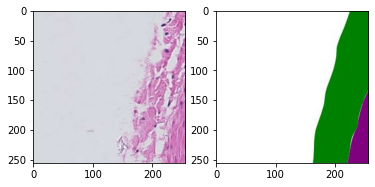

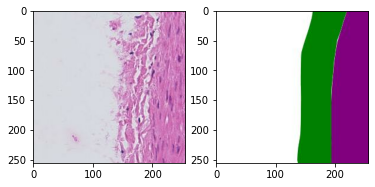

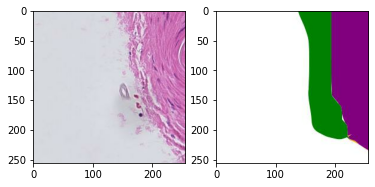

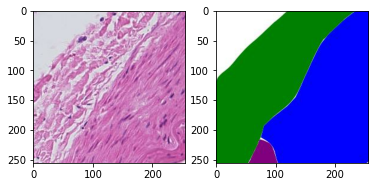

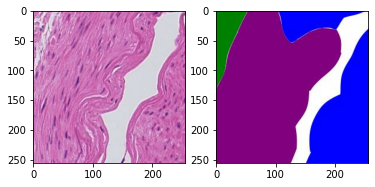

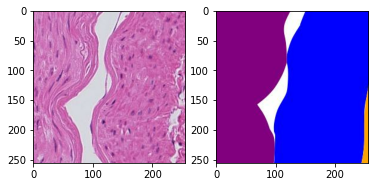

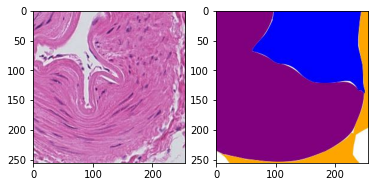

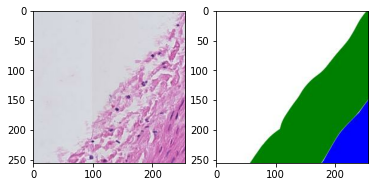

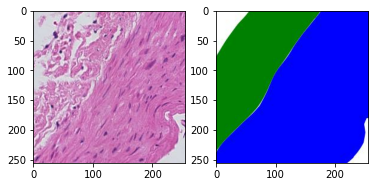

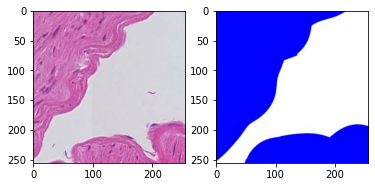

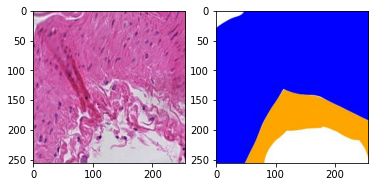

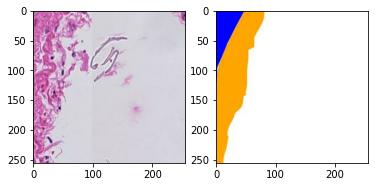

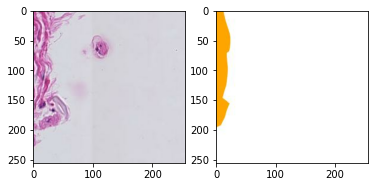

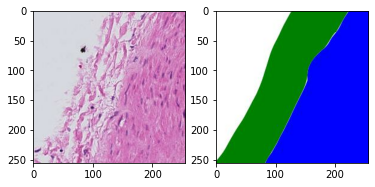

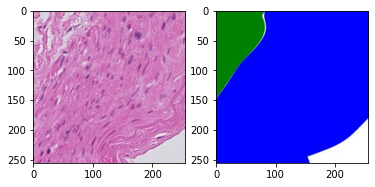

In [13]:
# Make an iterator to extract images from the tensor dataset
image_batches = tf.compat.v1.data.make_one_shot_iterator(image_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)

n_images_to_show = 15

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    image = image_batches.next().numpy().astype(np.uint8)
    mask = mask_batches.next().numpy().astype(np.uint8)
    
    #Plot the corresponding image and masks
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(image)
    fig.add_subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

In [14]:
DATA_PATH = '/content/drive/My Drive/segmentation/'

# Create folders to hold images and masks

folders = ['train_image/train', 'train_masks/train', 'val_image/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(DATA_PATH + folder)
    except Exception as e: print(e)

[Errno 17] File exists: '/content/drive/My Drive/segmentation/train_image/train'
[Errno 17] File exists: '/content/drive/My Drive/segmentation/train_masks/train'
[Errno 17] File exists: '/content/drive/My Drive/segmentation/val_image/val'
[Errno 17] File exists: '/content/drive/My Drive/segmentation/val_masks/val'


In [0]:
def generate_image_folder_structure(image, masks, image_list, masks_list):
    '''Function to save images in the appropriate folder directories 
        Inputs: 
            image - image tensor dataset
            masks - mask tensor dataset
            image_list - image file paths
            masks_list - mask file paths
    '''
    #Create iterators for image and masks
    image_batches = tf.compat.v1.data.make_one_shot_iterator(image)  # outside of TF Eager, we would use make_one_shot_iterator
    mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks)
    
    #Iterate over the train images while saving the image and masks in appropriate folders
    dir_name='train'
    for file in zip(image_list[:-round(0.2*len(image_list))],masks_list[:-round(0.2*len(masks_list))]):
        
        
        #Convert tensors to numpy arrays
        image = image_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        #Save image and masks to correct directories
        image.save(DATA_PATH+'{}_image/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])

         #Iterate over the val images while saving the image and masks in appropriate folders
    dir_name='val'
    for file in zip(image_list[-round(0.2*len(image_list)):],masks_list[-round(0.2*len(masks_list)):]):
        
        
        #Convert tensors to numpy arrays
        image = image_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        #Save image and masks to correct directories
        image.save(DATA_PATH+'{}_image/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    print("Saved {} image to directory {}".format(len(image_list),DATA_PATH))
    print("Saved {} masks to directory {}".format(len(masks_list),DATA_PATH))
    
generate_image_folder_structure(image_tensors, masks_tensors, image_list, masks_list)

#generate_image_folder_structure(train_image, train_masks, val_files, 'val')

In [0]:
label_codes=[(128,0,0),(128,0,128),(0,0,255),(0,128,0),(255,255,0),(255,105,180),(255,0,0),(255,165,0),(128,128,128),(255,255,255)]

In [0]:
label_names=['Dark_dense_distribution', 'Elongated_nuclei','Light_dense_istribution','Light_distribution',
           'No_nuclei_with_uniform_texture','No_nuclei_with_unstructured','Red_texture',  'Round_nuclei','Mixed','background']

In [0]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [0]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [20]:
id2code

{0: (128, 0, 0),
 1: (128, 0, 128),
 2: (0, 0, 255),
 3: (0, 128, 0),
 4: (255, 255, 0),
 5: (255, 105, 180),
 6: (255, 0, 0),
 7: (255, 165, 0),
 8: (128, 128, 128),
 9: (255, 255, 255)}

In [21]:
id2name

{0: 'Dark_dense_distribution',
 1: 'Elongated_nuclei',
 2: 'Light_dense_istribution',
 3: 'Light_distribution',
 4: 'No_nuclei_with_uniform_texture',
 5: 'No_nuclei_with_unstructured',
 6: 'Red_texture',
 7: 'Round_nuclei',
 8: 'Mixed',
 9: 'background'}

In [0]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [0]:
# Normalizing only images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_image_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_image_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

In [0]:
def TrainAugmentGenerator(seed = 1, batch_size = 5):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_image_datagen.flow_from_directory(
    DATA_PATH + 'train_image/',
    batch_size = batch_size, seed = seed)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    DATA_PATH + 'train_masks/',
    batch_size = batch_size, seed = seed)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 1, batch_size = 5):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_image_datagen.flow_from_directory(
    DATA_PATH + 'val_image/',
    batch_size = batch_size, seed = seed)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

In [0]:
def get_small_unet(n_filters = 16, bn = True, dilation_rate = 1):
    '''Validation Image data generator
        Inputs: 
            n_filters - base convolution filters
            bn - flag to set batch normalization
            dilation_rate - convolution dilation rate
        Output: Unet keras Model
    '''
    #Define input batch shape
    batch_shape=(256,256,3)
    inputs = Input(batch_shape=(5, 256, 256, 3))
    print(inputs)
    
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)
        
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
    if bn:
        conv2 = BatchNormalization()(conv2)
        
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool2)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool3)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool4)
    if bn:
        conv5 = BatchNormalization()(conv5)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv5)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv8)
    if bn:
        conv8 = BatchNormalization()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv10 = Conv2D(10, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate)(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

In [44]:
model = get_small_unet(n_filters = 32)

Tensor("input_2:0", shape=(5, 256, 256, 3), dtype=float32)


In [0]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [0]:
smooth = 1.

In [0]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[tversky_loss,dice_coef,'accuracy'])

In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(5, 256, 256, 3)]   0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (5, 256, 256, 32)    896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (5, 256, 256, 32)    128         conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (5, 256, 256, 32)    9248        batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [0]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='segmentation_model_150_epochs_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=30, verbose=1)
callbacks = [tb, mc, es]

In [51]:
batch_size = 5
steps_per_epoch = np.ceil(float(len(image_list) - round(0.1*len(image_list))) / float(batch_size))
steps_per_epoch

50.0

In [52]:
validation_steps = (float((round(0.1*len(image_list)))) / float(batch_size))
validation_steps

5.6

In [0]:
num_epochs = 100

In [57]:
# Train model

batch_size = 5
result = model.fit_generator(TrainAugmentGenerator(), steps_per_epoch=50 ,
                validation_data = ValAugmentGenerator(), validation_steps = 5,epochs=num_epochs, 
                 callbacks=callbacks)
model.save_weights("segmentation_model_150_epochs.h5", overwrite=True)

Found 222 images belonging to 1 classes.
Found 222 images belonging to 1 classes.
Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.1512 - tversky_loss: 9.5727 - dice_coef: 0.5983 - accuracy: 0.3443Found 56 images belonging to 1 classes.
Found 56 images belonging to 1 classes.

Epoch 00001: accuracy did not improve from 0.41641
50/50 [==============================] - 11s 223ms/step - loss: 0.1512 - tversky_loss: 9.5727 - dice_coef: 0.5983 - accuracy: 0.3443 - val_loss: 0.2227 - val_tversky_loss: 9.8882 - val_dice_coef: 0.2177 - val_accuracy: 0.0450
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.1465 - tversky_loss: 9.5666 - dice_coef: 0.5971 - accuracy: 0.3348
Epoch 00002: accuracy did not improve from 0.41641
50/50 [==============================] - 11s 217ms/step - loss: 0.1465 - tversky_loss: 9.5666 - dice_coef: 0.5971 - accuracy: 0.3348 - val_loss: 0.0236 - val_tversky_loss: 9.7516 - val_dice_coef: 0.3375 - val_accuracy: 0.1746
Epoch 3/

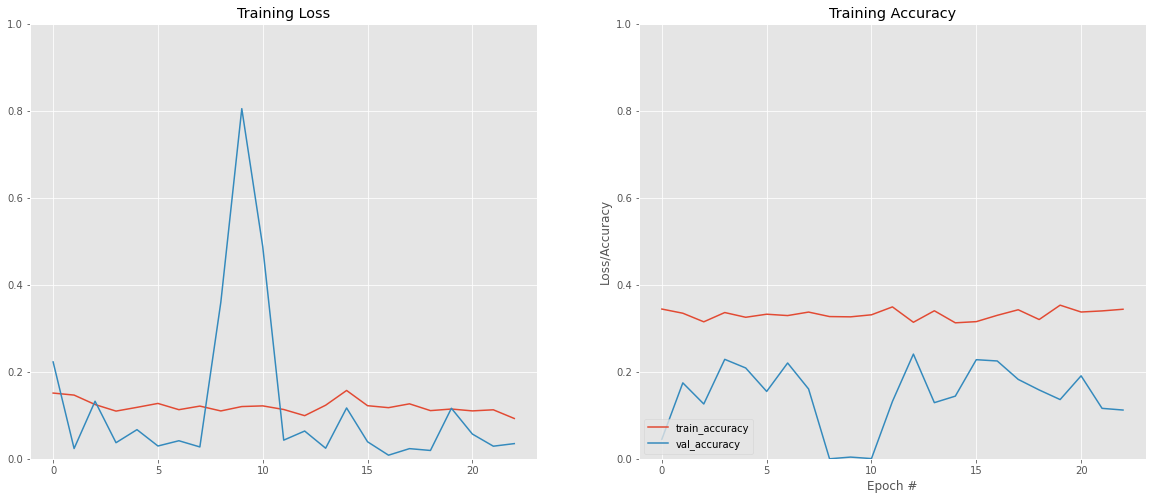

In [58]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), result.history["val_accuracy"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [0]:
testing_gen = ValAugmentGenerator()

In [60]:
batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

Found 56 images belonging to 1 classes.
Found 56 images belonging to 1 classes.


(5, 256, 256, 10)

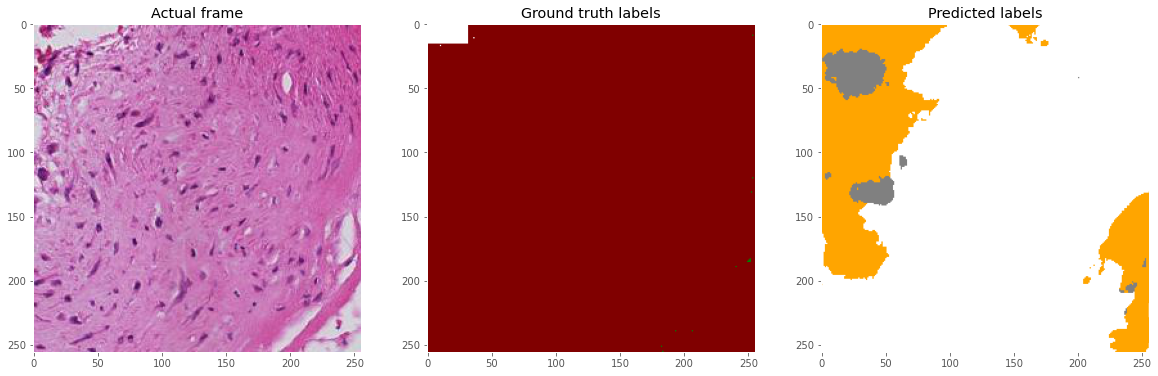

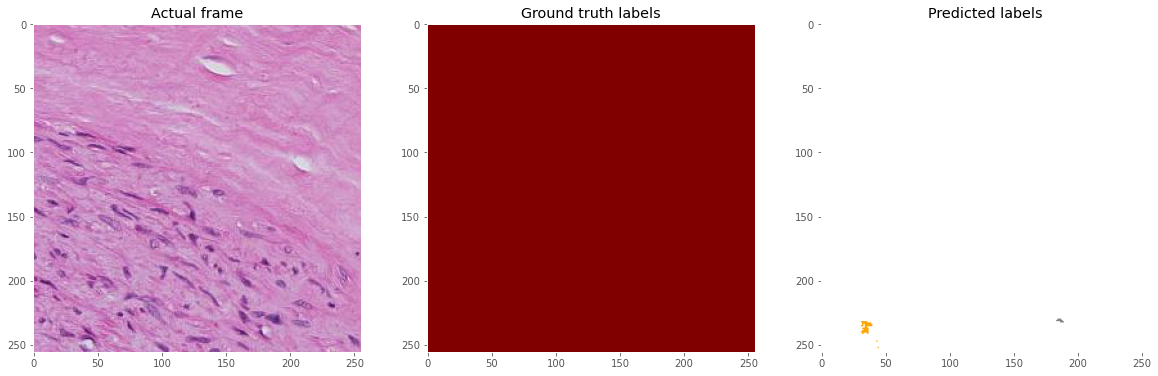

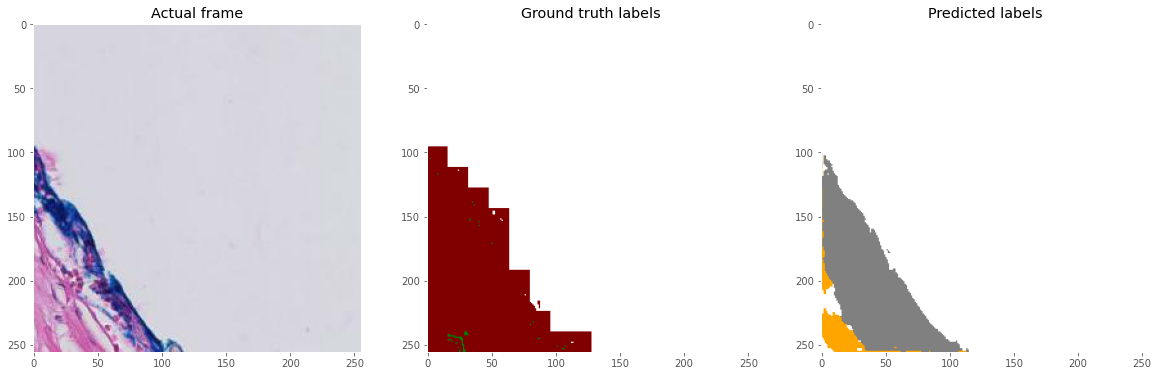

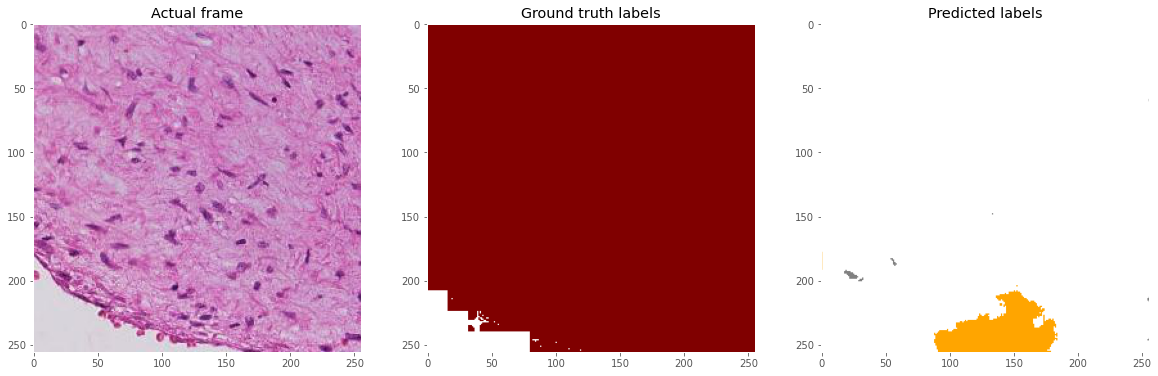

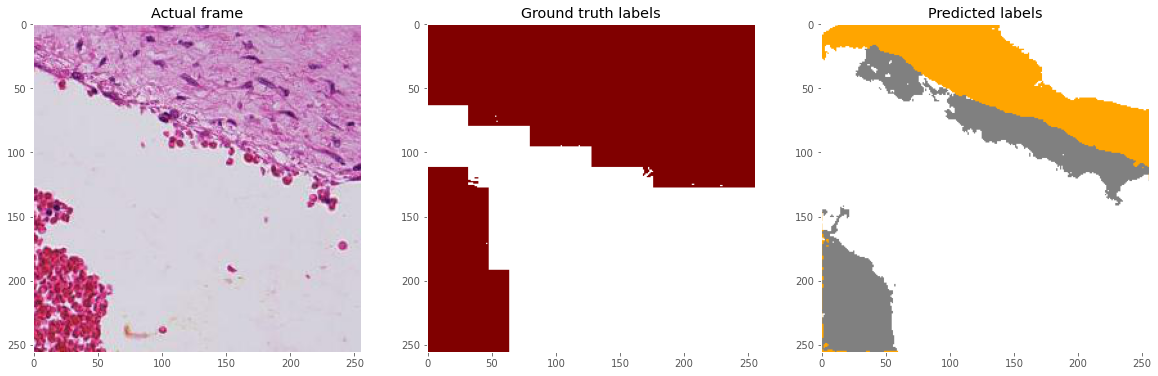

In [61]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual image')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(pred_all[i],id2code))
    ax3.grid(b=None)
    
    plt.show()